# I-JEPA with VGG16 as Context and Target Encoders

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import clone_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import numpy as np

2024-12-02 22:28:07.424032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733178488.405278       9 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733178488.639200       9 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 22:28:14.707008: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


2024-12-02 22:28:25.081698: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-12-02 22:28:25.081735: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: c61bfa7cac67
2024-12-02 22:28:25.081751: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: c61bfa7cac67
2024-12-02 22:28:25.081872: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 565.57.1
2024-12-02 22:28:25.081912: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 565.57.1
2024-12-02 22:28:25.081924: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 565.57.1


## Load the dataset


In [2]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 444s 3us/step


In [3]:
def generate_blocks(image, block_size=4, num_target_patches=4):
    """
    Generate masked target patches and a context image with patches removed.

    Args:
        image (np.ndarray): Input image as a 2D NumPy array.
        block_size (int): Size of each block.
        num_target_patches (int): Number of target patches to generate.

    Returns:
        tuple: A tuple containing:
            - context (np.ndarray): Image with target patches removed.
            - target_patches (list[np.ndarray]): List of target patches.
    """
    # Ensure image dimensions are divisible by block_size
    image_height, image_width = image.shape[0], image.shape[1]
    assert image_height % block_size == 0, "Image height must be divisible by block_size"
    assert image_width % block_size == 0, "Image width must be divisible by block_size"
    num_rows = image_height // block_size
    num_cols = image_width // block_size

    # Calculate patch indices directly as NumPy arrays
    patch_row_indices = np.arange(0, image_height, block_size)
    patch_col_indices = np.arange(0, image_width, block_size)

    # Initialize context image
    context = image.copy()

    target_patches = []
    target_patch_coords = []
    for _ in range(num_target_patches):
        # Randomly select top-left coordinates for the patch
        top_left_y = np.random.choice(patch_row_indices)
        top_left_x = np.random.choice(patch_col_indices)

        # Randomly determine patch size within bounds
        bottom_right_y = min(
            top_left_y + np.random.choice(np.arange(2 * block_size, 8 * block_size, block_size)),
            image_height
        )
        bottom_right_x = min(
            top_left_x + np.random.choice(np.arange(2 * block_size, 8 * block_size, block_size)),
            image_width
        )

        # Extract the patch directly without copying
        target_patch = np.zeros_like(image)
        target_patch[top_left_y:bottom_right_y, top_left_x:bottom_right_x] = \
            image[top_left_y:bottom_right_y, top_left_x:bottom_right_x]

        # Add the target patch to the list
        target_patches.append(target_patch)

        # Add target patch coords to the list
        target_patch_coords.append((top_left_y, top_left_x, bottom_right_y, bottom_right_x))

        # Remove the patch from the context image
        context[top_left_y:bottom_right_y, top_left_x:bottom_right_x] = 0

    return context, target_patches, target_patch_coords


Target coords:
(np.int64(24), np.int64(24), 32, 32)
(np.int64(24), np.int64(16), 32, np.int64(32))
(np.int64(12), np.int64(4), 32, np.int64(20))
(np.int64(20), np.int64(24), 32, 32)


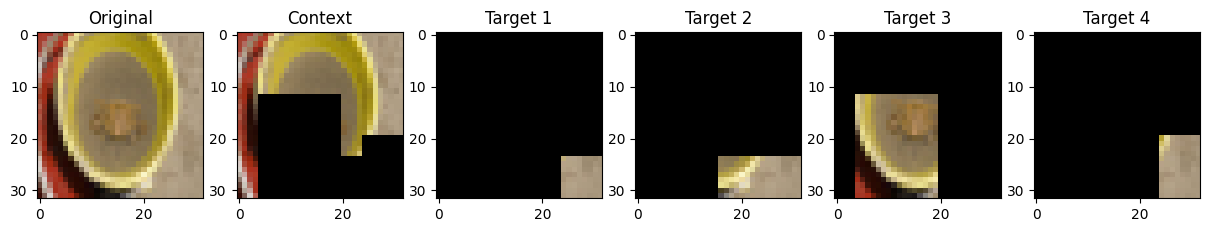

In [4]:
# Example context and target blocks

# choose a random int between 0 and 50000
random_int = np.random.randint(0, 50000)

# Generate blocks
context, target_patches, target_patch_coords = generate_blocks(x_train[random_int])

# Create a figure to show 6 images in a row
fig, axs = plt.subplots(1, 6, figsize=(15, 5))

# Show original in the first column
axs[0].imshow(x_train[random_int])
axs[0].set_title('Original')

# Show context in the second column
axs[1].imshow(context)
axs[1].set_title('Context')

# Show the targets in the rest of the columns
for i in range(2, 6):
    axs[i].imshow(target_patches[i-2])
    axs[i].set_title(f'Target {i-1}')

# Print target coords
print("Target coords:")
for coord in target_patch_coords:
    print(coord)

# Show the plot
plt.show()

In [5]:
def init_encoder():

    encoder = VGG16(include_top=False, input_shape=(32, 32, 3))
    for layer in encoder.layers:
        layer.trainable = True

    # Add a global average pooling layer to collapse spatial dimensions
    x = GlobalAveragePooling2D()(encoder.output)

    # Create the new model
    model = Model(inputs=encoder.input, outputs=x)

    return model

context_encoder = init_encoder()
target_encoder = clone_model(context_encoder)

2024-12-02 22:19:39.410065: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (34)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


In [6]:
context_encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
target_encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ keras_tensor (InputLayer)       │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Input layers
context_input = Input(shape=(512,), name='context_input')  # Context encoding
coords_input = Input(shape=(4,), name='coords_input')      # Target patch coordinates

# Concatenate the inputs
x = Concatenate(name='concat_features')([context_input, coords_input])

# Dense layers to process the combined input
x = Dense(1024, activation='relu', name='dense1')(x)
x = Dense(512, activation='relu', name='dense2')(x)

# Output layer
output = Dense(512, activation='relu', name='output_vector')(x)

# Create the model
predictor_model = Model(inputs=[context_input, coords_input], outputs=output, name='predictor_model')

# Model summary
predictor_model.summary()


Model: "predictor_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ context_input       │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ coords_input        │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_features     │ (None, 516)       │          0 │ context_input[0]… │
│ (Concatenate)       │                   │            │ coords_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 1024)      │    529,408 │ concat_features[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 512)       │    524,800 │ dense1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_vector       │ (None, 512)       │    262,656 │ dense2[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,316,864 (5.02 MB)

 Trainable params: 1,316,864 (5.02 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Training Parameters
epochs = 10
batch_size = 32
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss_fn = tf.keras.losses.MeanSquaredError()

# EMA Momentum Parameters
initial_momentum = 0.996
final_momentum = 1.0

In [11]:
! pip install tqdm


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [12]:
from tqdm import tqdm  # Import tqdm for the progress bar

# Training Loop
for epoch in range(epochs):
    total_loss = 0  # Track cumulative loss for the epoch
    num_batches = len(x_train) // batch_size  # Total number of batches
    current_momentum = initial_momentum + (epoch / epochs) * (final_momentum - initial_momentum)

    print(f"Epoch {epoch + 1}/{epochs}")
    with tqdm(total=num_batches, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as pbar:
        for step in range(num_batches):
            # Create a batch of images
            batch_images = x_train[step * batch_size:(step + 1) * batch_size]

            # Generate context and target patches
            batch_contexts, batch_targets, batch_coords = [], [], []
            for img in batch_images:
                context, targets, coords = generate_blocks(img)
                batch_contexts.append(context)
                batch_targets.extend(targets)  # Flatten target patches
                batch_coords.extend(coords)   # Flatten coordinates

            # Convert to numpy arrays and preprocess
            batch_contexts = np.array(batch_contexts) / 255.0
            batch_targets = np.array(batch_targets) / 255.0
            batch_coords = np.array(batch_coords, dtype=np.float32)

            # Encode context and target patches (silent predictions)
            batch_context_encodings = context_encoder.predict(batch_contexts, verbose=0)
            batch_target_encodings = target_encoder.predict(batch_targets, verbose=0)

            # Repeat context encodings to match target patches
            batch_context_encodings = np.repeat(batch_context_encodings, len(batch_coords) // batch_size, axis=0)

            # Training step
            with tf.GradientTape() as tape:
                # Predict using predictor model
                predictions = predictor_model([batch_context_encodings, batch_coords])
                # Calculate loss
                loss = loss_fn(batch_target_encodings, predictions)

            # Compute gradients
            gradients = tape.gradient(loss, predictor_model.trainable_variables + context_encoder.trainable_variables)
            # Apply gradients
            optimizer.apply_gradients(zip(gradients, predictor_model.trainable_variables + context_encoder.trainable_variables))

            # Update loss and progress bar
            total_loss += loss.numpy()
            pbar.update(1)  # Increment progress bar

            # Update target encoder weights at the end of the epoch
            for var, target_var in zip(context_encoder.variables, target_encoder.variables):
                target_var.assign(current_momentum * target_var + (1 - current_momentum) * var)

    # Print epoch loss
    epoch_loss = total_loss / num_batches
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f},  Momentum: {current_momentum:.4f}")


Epoch 1/10


Epoch 1/10:   0%|                                   | 0/1562 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:731: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
Epoch 1/10:   6%|█▍                        | 88/1562 [02:06<35:27,  1.44s/batch]


KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

# Freeze the target encoder
for layer in target_encoder.layers:
    layer.trainable = False

# Build linear probing model
def build_linear_probe_model(encoder, num_classes):
    # Input for image
    input_layer = Input(shape=(32, 32, 3), name="image_input")

    # Pass input through the frozen encoder
    x = encoder(input_layer)

    # Add linear classification head
    output_layer = Dense(num_classes, activation="softmax", name="classification_head")(x)

    # Build model
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Create the linear probing model
num_classes = 100  # CIFAR-100 has 100 classes
linear_probe_model = build_linear_probe_model(target_encoder, num_classes)


In [ ]:
# Compile the model
linear_probe_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
# Load CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

# Normalize the images
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Train the linear probing model
history = linear_probe_model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=64,
    epochs=20
)


Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.1334 - loss: 3.9380 - val_accuracy: 0.2592 - val_loss: 3.1239
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.2761 - loss: 3.0232 - val_accuracy: 0.2948 - val_loss: 2.9132
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3130 - loss: 2.8224 - val_accuracy: 0.3165 - val_loss: 2.8143
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3370 - loss: 2.7015 - val_accuracy: 0.3263 - val_loss: 2.7592
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.3519 - loss: 2.6168 - val_accuracy: 0.3346 - val_loss: 2.7170
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.3624 - loss: 2.5496 - val_accuracy: 0.3428 - val_loss: 2.6769
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.3690 - loss: 2.5052 - val_accuracy: 0.3460 - val_loss: 2.6544
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.3785 - loss: 2.4606 - v

In [ ]:
# Evaluate on the test set
test_loss, test_accuracy = linear_probe_model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3672 - loss: 2.5633
Test Accuracy: 36.50%
